#   Signature Trader in mean-reversion

In [8]:
import strat
from strat import mean_reversion_data
import torch
import useful
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

plt.style.use('ggplot') 
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['lines.linewidth'] = 2.5 

seed=2024
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### 1. Get  data

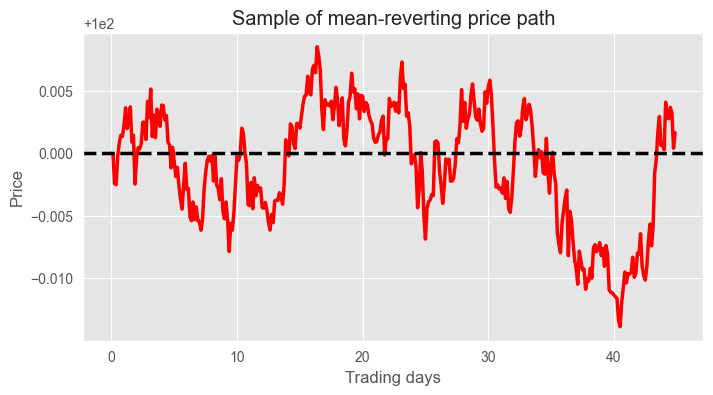

In [9]:
X_0 = 100
sigma_x = 0.07
k = 100
batch_len = 1000
n_trading_days=252
T = 45 /n_trading_days # num of days for trading /num of trading days in a year
rate = n_trading_days*8 # hourly data
dt = 1/rate ; drift = 0

simulated_mean_reversion_data = mean_reversion_data(T, dt, X_0, sigma_x, k,batch_len)
sample_paths = X_0 + simulated_mean_reversion_data + drift*torch.arange(0, T, dt).reshape(1, -1, 1)
N = sample_paths.shape[1]
exogenous_signal = torch.zeros(batch_len, N, 0) # no info data


index = random.randint(0, batch_len) # for plot

plt.plot(np.arange(0,T*n_trading_days,dt*n_trading_days),sample_paths[index], color='red')
plt.axhline(y=X_0, color='k', linestyle='--')
plt.xlabel("Trading days")
plt.ylabel("Price")
plt.title("Sample of mean-reverting price path")

workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/Meanrevert_sample_path.pdf', format='pdf')

plt.show()

### 2. Signature trading fitting

In [10]:
# Signature trader fitting
depth = 1
dt = 1 # var(PnL) <= sqrt(delta) (optimization constraint)
Signature_elements = strat.Signature_Trading(depth, dt)
Signature_elements.main_fitting_process(sample_paths, exogenous_signal)

# deal with mean-reverting property

for func in range(Signature_elements.d):
    Signature_elements.l[func] = -Signature_elements.l[func]


mu_sig is ok
sigma_sig is ok
lambda is ok
l_1
Signature level 0:
tensor([-32.5384])
Signature level 1:
tensor([7.0902e-02, 2.5892e+04])
fitting process is ok


### 3. Signature trader on IS 

In [11]:
total_trading_assets = 10 # Number of mean-reverting assets involved in trading
pnl_per_assets= torch.zeros(total_trading_assets, N)

for pair_index in range(total_trading_assets):
    
    mean_revert_data = sample_paths[pair_index, :, :]
    signal_data = exogenous_signal[pair_index, :, :]
    
    # Trading pos. based on signature elements
    xi = Signature_elements.sig_trader(mean_revert_data, signal_data)
    pnl_for_current_asset = Signature_elements.get_PnL(mean_revert_data, xi) # Calculate the hourly PnL for the current asset
    hourly_pnl_pair = torch.sum(pnl_for_current_asset, dim=1)
    pnl_per_assets[pair_index, 1:] = hourly_pnl_pair # Update the PnL for the current pair

total_hourly_pnl = torch.sum(pnl_per_assets, dim=0)
cumulative_pnl_portfolio = torch.cumsum(total_hourly_pnl, dim=0)


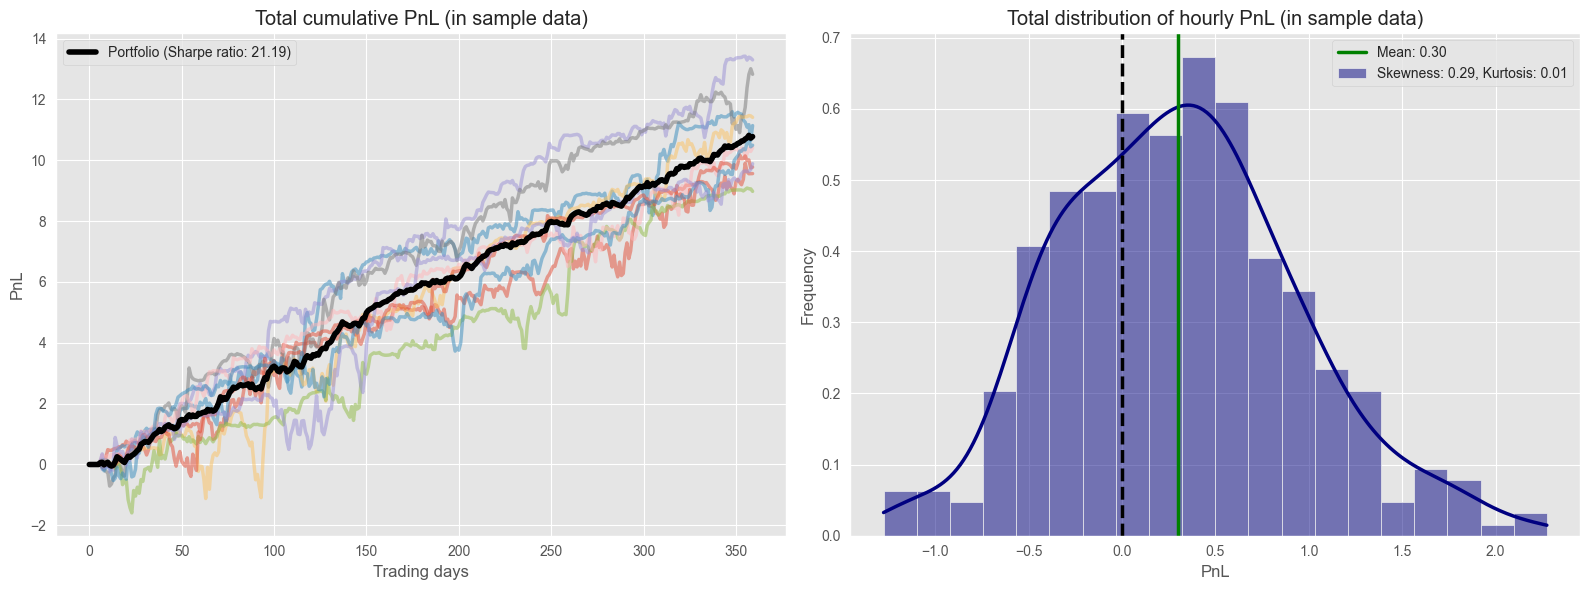

In [12]:
total_trading_assets = len(pnl_per_assets)
total_mean_return = torch.mean(total_hourly_pnl)
total_std_return = torch.std(total_hourly_pnl)
total_sharpe_ratio = total_mean_return / total_std_return * np.sqrt(rate)


norm_ptf_cum_pnl = cumulative_pnl_portfolio / total_trading_assets
H_pnl_mean = torch.mean(total_hourly_pnl)
H_pnl_std = torch.std(total_hourly_pnl)
H_pnl_skew = torch.mean((total_hourly_pnl - H_pnl_mean)**3) / H_pnl_std**3
H_pnl_kurtosis = torch.mean((total_hourly_pnl - H_pnl_mean)**4) / H_pnl_std**4 - 3


fig, axes = plt.subplots(1,2, figsize=(16,6))  


for asset in range(total_trading_assets):
    axes[0].plot(torch.cumsum(pnl_per_assets[asset,:], dim=0), alpha=0.5)

axes[0].plot(norm_ptf_cum_pnl, lw=4, color='k', label=f'Portfolio (Sharpe ratio: {total_sharpe_ratio:.2f})')
axes[0].set_title("Total cumulative PnL (in sample data)")
axes[0].set_xlabel("Trading days")
axes[0].set_ylabel("PnL")
axes[0].legend()


sns.histplot(total_hourly_pnl, ax=axes[1], color='navy', kde=True, bins=20, stat='density', label=f'Skewness: {H_pnl_skew:.2f}, Kurtosis: {H_pnl_kurtosis:.2f}')
axes[1].axvline(x=0, color='black', ls='--')
axes[1].axvline(x=H_pnl_mean, color='green', label=f'Mean: {H_pnl_mean:.2f}')
axes[1].set_title("Total distribution of hourly PnL (in sample data)")
axes[1].set_xlabel("PnL")
axes[1].set_ylabel("Frequency")
axes[1].legend()

workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/Meanrevert_perf_IS.pdf', format='pdf')

plt.tight_layout()  
plt.show()

### 4. Trade on out-of-sample data

In [16]:
# OOS 
n_assets_for_trading = 10 

X_0 = 100
sigma_x = 0.07
k = 100
batch_len = 1000
n_trading_days=252
T = 45 /n_trading_days # num of days for trading /num of trading days in a year
rate = n_trading_days*8 # hourly data
dt = 1/rate ; drift = 0



oos_MR = mean_reversion_data(T=T, dt=dt, X_0=X_0, sigma_x=sigma_x, k=k,batch_len=n_assets_for_trading)
oos_sample_paths = X_0 + oos_MR + drift*torch.arange(0, T, dt).reshape(1, -1, 1)
oos_exogenous_data = torch.zeros((n_assets_for_trading, N, 0)) # f = emptyset
N = oos_sample_paths.shape[1]
oos_H_pnl = torch.zeros(n_assets_for_trading, N) 

for asset in range(n_assets_for_trading):

    X = oos_sample_paths[asset,:,:]
    f = oos_exogenous_data[asset,:,:]
    xi = Signature_elements.sig_trader(X, f)
    oos_H_pnl[asset,1:] = Signature_elements.get_PnL(X, xi)[:,0] 

oos_total_hourly_pnl = torch.sum(oos_H_pnl, dim=0) 
oos_cumulative_pnl_portfolio = torch.cumsum(oos_total_hourly_pnl, dim=0)

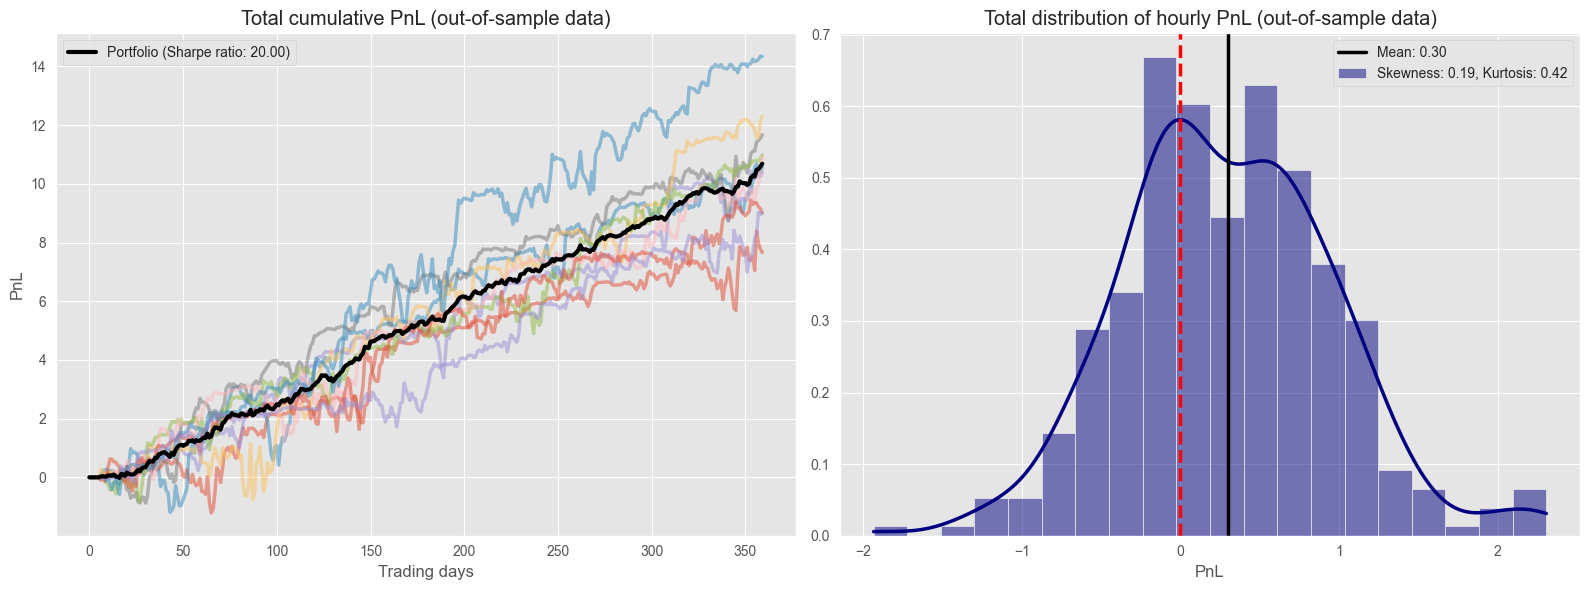

In [17]:
total_trading_assets = oos_H_pnl.shape[0]
oos_total_mean_return = torch.mean(oos_total_hourly_pnl)
oos_total_std_return = torch.std(oos_total_hourly_pnl)
oos_total_sharpe_ratio = oos_total_mean_return / oos_total_std_return * np.sqrt(rate)

# Calculate  statistics for hourly PnL
oos_H_pnl_mean = torch.mean(oos_total_hourly_pnl)
oos_H_pnl_std = torch.std(oos_total_hourly_pnl)
oos_H_pnl_skew = torch.mean((oos_total_hourly_pnl - oos_H_pnl_mean)**3) / oos_H_pnl_std**3
oos_H_pnl_kurtosis = torch.mean((oos_total_hourly_pnl - oos_H_pnl_mean)**4) / oos_H_pnl_std**4 - 3


fig, axes = plt.subplots(1,2, figsize=(16,6))  


for asset in range(total_trading_assets):
    axes[0].plot(torch.cumsum(oos_H_pnl[asset,:], dim=0), alpha=0.5)

norm_ptf_cum_pnl = oos_cumulative_pnl_portfolio / n_assets_for_trading
axes[0].plot(norm_ptf_cum_pnl, lw=3, color='black', label=f'Portfolio (Sharpe ratio: {oos_total_sharpe_ratio:.2f})')
axes[0].set_title("Total cumulative PnL (out-of-sample data)")
axes[0].set_xlabel("Trading days")
axes[0].set_ylabel("PnL")
axes[0].legend()


sns.histplot(oos_total_hourly_pnl, ax=axes[1], color='navy', kde=True, bins=20, stat='density', label=f'Skewness: {oos_H_pnl_skew:.2f}, Kurtosis: {oos_H_pnl_kurtosis:.2f}')
axes[1].axvline(x=0, color='red', ls='--')
axes[1].axvline(x=oos_H_pnl_mean, color='black', label=f'Mean: {oos_H_pnl_mean:.2f}')
axes[1].set_title("Total distribution of hourly PnL (out-of-sample data)")
axes[1].set_xlabel("PnL")
axes[1].set_ylabel("")
axes[1].legend()


workspace='C:/Users/alpho/Desktop/R&D/2-en cours/SIGNATORY/Projet_signature_trading_Alphonse'

plt.savefig(workspace+'/img/Meanrevert_perf_OOS.pdf', format='pdf')

plt.tight_layout()
plt.show()


Our signature trader shows consistent performance on both in-sample and out-of-sample data, indicating that it generalizes well without over-fitting, and capture mean-reverting trading signals effectively.